# Realtive importance analysis

In [1]:
#! pip install pingouin

In [2]:
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Optional
import json

import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import pingouin as pg
import xarray as xr
import proplot as plot

print(f"numpy:    {np.__version__}")
print(f"pandas:   {pd.__version__}")
print(f"pingouin: {pg.__version__}")
print(f"xarray:   {xr.__version__}")
print(f"plot:   {plot.__version__}")



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


numpy:    1.22.1
pandas:   1.4.3
pingouin: 0.5.2
xarray:   2022.3.0
plot:   0.9.5


In [3]:
from subprocess import check_output, CalledProcessError
from functools import lru_cache

@lru_cache(maxsize=1)
def root():
    ''' returns the absolute path of the repository root '''
    try:
        base = check_output('git rev-parse --show-toplevel', shell=True)
    except CalledProcessError:
        raise IOError('Current working directory is not a git repository')
    return Path(base.decode('utf-8').strip())

In [4]:
@dataclass
class RelaImpoResult:
    r2: float
    r2adj: float
    covariates: List[str]
    importances: List[float]
    domain: Optional[str] = 'undefined'

In [5]:
# parameters
inpath = root() / "data" 
outpath = root() / "data" / "analysis" / "relaimpo"

In [6]:
outpath.mkdir(exist_ok=True)

In [7]:
def plot_pdf_png(fig, name:str, out_path:Path=outpath, dpi:int=300):
    """ write plots as png and pdf """
    fig.save(out_path / (name + '.png'), dpi=dpi, transparent=False)
    fig.save(out_path / (name + '.pdf'))


In [8]:
# extra stuff for admin panel [label positions]
Dreg = {k+1:v for k, v in enumerate(['Mekong River', 'North-East', 'South-East', 'Red River', 'North-C. Coast', 'South-C. Coast', 'North-West', 'Central Highl.'])}
Dreg

{1: 'Mekong River',
 2: 'North-East',
 3: 'South-East',
 4: 'Red River',
 5: 'North-C. Coast',
 6: 'South-C. Coast',
 7: 'North-West',
 8: 'Central Highl.'}

In [9]:
covariates = ['CLPC', 'SDTO', 'TOTC', 'TOTN', 'PHAQ', 'BULK', 'dC_fertilizer', 'dN_fertilizer', 'dC_residue', 'irrigation', 'surfacetemperature']

## Preprocess data

In [10]:
model = xr.open_dataset(inpath / "intermediate" / "annual_samples.nc")
model

<xarray.Dataset>
Dimensions:             (sample: 500, year: 10, lat: 186, lon: 96)
Coordinates:
  * lon                 (lon) float64 101.5 101.6 101.7 ... 109.3 109.4 109.5
  * lat                 (lat) float64 8.042 8.125 8.208 ... 23.29 23.38 23.46
  * year                (year) int64 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * sample              (sample) int64 0 100 101 102 103 104 ... 96 97 98 99 9
Data variables: (12/17)
    irrigation          (sample, year, lat, lon) float64 ...
    precipitation       (sample, year, lat, lon) float64 ...
    DW_above            (sample, year, lat, lon) float64 ...
    C_stubble           (sample, year, lat, lon) float64 ...
    DW_fru_export       (sample, year, lat, lon) float64 ...
    C_plant_litter      (sample, year, lat, lon) float64 ...
    ...                  ...
    dN_nh3_emis         (sample, year, lat, lon) float64 ...
    dN_fertilizer       (sample, year, lat, lon) float64 ...
    dC_fertilizer       (sample, year, lat, lon) float64 ...
    dC_residue          (sample, year, lat, lon) float64 ...
    surfacewater        (sample, year, lat, lon) float64 ...
    surfacetemperature  (sample, year, lat, lon) float64 ...

In [11]:
misc = xr.open_dataset(inpath / "raw" / "misc" / "VN_MISC5_V2.nc")

In [12]:
subset_output = model[[x for x in model.data_vars if x in covariates] + ['dC_ch4_emis', 'dN_n2o_emis']]

In [13]:
soil = xr.open_dataset(inpath / "raw" / "misc" / "GLOBAL_WISESOIL_S1_HR.nc").sel(
    lat=slice(misc.lat.min()-0.001, misc.lat.max()+0.001), 
    lon=slice(misc.lon.min()-0.001, misc.lon.max()+0.001)
).sel(lev=1, drop=True)

In [14]:
subset_soil = soil[[x for x in soil.data_vars if x in covariates]]

In [15]:
merged = xr.merge(xr.align(misc, subset_soil, subset_output, join='override'))
merged

<xarray.Dataset>
Dimensions:             (lon: 96, lat: 186, sample: 500, year: 10)
Coordinates:
  * lon                 (lon) float64 101.5 101.6 101.7 ... 109.3 109.4 109.5
  * lat                 (lat) float64 8.042 8.125 8.208 ... 23.29 23.38 23.46
  * year                (year) int64 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * sample              (sample) int64 0 100 101 102 103 104 ... 96 97 98 99 9
Data variables: (12/27)
    mask                (lat, lon) float32 ...
    simmask             (lat, lon) float32 ...
    area_ha             (lat, lon) float32 ...
    regionid            (lat, lon) float32 ...
    provinceid          (lat, lon) float32 ...
    soilid              (lat, lon) float32 ...
    ...                  ...
    dN_fertilizer       (sample, year, lat, lon) float64 ...
    dC_fertilizer       (sample, year, lat, lon) float64 ...
    dC_residue          (sample, year, lat, lon) float64 ...
    surfacetemperature  (sample, year, lat, lon) float64 ...
    dC_ch4_emis         (sample, year, lat, lon) float64 ...
    dN_n2o_emis         (sample, year, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/...
    history:      Wed Aug 12 09:58:21 2015: cdo div VN_MISC_a.nc testmask.nc ...
    institution:  Biodiversity and Climate Research Center (BIK-F), Frankfurt...
    Conventions:  CF-1.4
    version:      0.1
    author:       Christian Werner
    project:      ILRI GHG Vietnam
    CDO:          Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/...

In [16]:
df_full = merged.to_dataframe().dropna().reset_index()
df_full.head()

,lon,lat,sample,year,mask,simmask,area_ha,regionid,provinceid,soilid,...,SDTO,TOTC,TOTN,irrigation,dN_fertilizer,dC_fertilizer,dC_residue,surfacetemperature,dC_ch4_emis,dN_n2o_emis
0,102.791667,22.375,0,2010,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,618.093333,0.007837,0.034949,0.080610,18.544012,-0.000007,0.000327
1,102.791667,22.375,0,2011,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,616.064868,0.007837,0.034949,0.085511,17.147118,0.000002,0.000272
2,102.791667,22.375,0,2012,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,770.007176,0.007837,0.034949,0.083576,18.169851,-0.000005,0.000333
3,102.791667,22.375,0,2013,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,601.015354,0.007837,0.034949,0.082457,17.876338,-0.000007,0.000310
4,102.791667,22.375,0,2014,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,687.618196,0.007837,0.034949,0.080057,18.035239,0.000003,0.000274


In [17]:
# df = df_full.sample(frac=0.1)
# df.head()

## Regional relaimpo CH4, N2O

In [18]:
add_noise = False

regional_results_n2o = []
regional_results_ch4 = []

regions = list(range(1,9)) + [100]

for r in regions:
    print(r)
    if r < 100:
        df_reg = df_full[df_full.regionid == r]
        domain = Dreg[r]
    else:
        df_reg = df_full
        domain = "Total"
    
    X = df_reg[covariates]

    if add_noise:
        # add white noise to X
        np.random.seed(42)
        noise = (np.random.rand(*X.shape) - 0.5) * 0.001
        X = X + noise
    
    regression_result_n2o = pg.linear_regression(X, df_reg.dN_n2o_emis, relimp=True)
    regression_result_ch4 = pg.linear_regression(X, df_reg.dC_ch4_emis, relimp=True)

    rir_ch4 = RelaImpoResult(
        r2=regression_result_ch4.loc[0, 'r2'],
        r2adj=regression_result_ch4.loc[0, 'adj_r2'],
        covariates=regression_result_ch4.names[1:].values.tolist(),
        importances=regression_result_ch4.loc[1:, 'relimp_perc'].values.tolist(),
        domain=domain
    )

    rir_n2o = RelaImpoResult(
        r2=regression_result_n2o.loc[0, 'r2'],
        r2adj=regression_result_n2o.loc[0, 'adj_r2'],
        covariates=regression_result_n2o.names[1:].values.tolist(),
        importances=regression_result_n2o.loc[1:, 'relimp_perc'].values.tolist(),
        domain=domain
    )
    
    regional_results_ch4.append(rir_ch4)
    regional_results_n2o.append(rir_n2o)
    

1


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


2


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


3
4
5
6
7


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


8


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


100


In [19]:
table_n2o = pd.DataFrame(columns = regional_results_n2o[0].covariates)
table_ch4 = pd.DataFrame(columns = regional_results_ch4[0].covariates)

for r in regional_results_n2o:
    table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))

for r in regional_results_ch4:
    table_ch4 = table_ch4.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))

table_ch4

/tmp/ipykernel_1442/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_1442/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_1442/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_1442/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,CLPC,SDTO,TOTC,TOTN,PHAQ,BULK,dC_fertilizer,dN_fertilizer,dC_residue,irrigation,surfacetemperature
Mekong River,1.403717,1.970204,2.484467,2.420222,0.809375,1.866025,22.858858,27.641589,29.571101,8.020082,0.954359
North-East,5.183263,8.052954,12.303236,12.493207,12.973368,3.251613,1.246424,1.483621,24.608361,13.473138,4.930815
South-East,16.971465,21.756465,6.467046,10.327870,16.093981,10.188962,0.420321,0.435187,8.455575,4.835524,4.047605
Red River,3.743585,6.167048,1.799981,2.799218,2.064867,5.325123,7.966326,6.975269,21.756789,13.036993,28.364802
North-C. Coast,1.735583,2.885040,6.772161,7.907471,9.188668,1.940453,14.019250,21.164456,26.290543,7.196272,0.900102
South-C. Coast,16.290480,12.412587,5.857107,8.846020,4.020589,5.188965,1.815670,1.989228,35.127424,6.245982,2.205949
North-West,0.291199,0.560588,0.385669,0.533482,0.525522,0.223058,27.180841,42.406190,20.189843,7.325008,0.378600
Central Highl.,13.128106,16.103291,8.546967,10.874319,7.247975,4.094171,1.195007,1.193924,25.623381,11.016204,0.976655
Total,3.403114,6.392531,1.511217,1.430806,0.484930,2.841349,21.342908,22.968211,28.263237,8.230042,3.131655


In [20]:
# rename index
table_ch4.columns = ['Clay', 'Sand', 'C$_{soil}$', 'N$_{soil}$', 'pH', 'Bulk', 'C$_{fert}$', 'N$_{fert}$', 'C$_{residue}$', 'Irri.', 'Temp.']
table_n2o.columns = ['Clay', 'Sand', 'C$_{soil}$', 'N$_{soil}$', 'pH', 'Bulk', 'C$_{fert}$', 'N$_{fert}$', 'C$_{residue}$', 'Irri.', 'Temp.']
table_ch4

,Clay,Sand,C$_{soil}$,N$_{soil}$,pH,Bulk,C$_{fert}$,N$_{fert}$,C$_{residue}$,Irri.,Temp.
Mekong River,1.403717,1.970204,2.484467,2.420222,0.809375,1.866025,22.858858,27.641589,29.571101,8.020082,0.954359
North-East,5.183263,8.052954,12.303236,12.493207,12.973368,3.251613,1.246424,1.483621,24.608361,13.473138,4.930815
South-East,16.971465,21.756465,6.467046,10.327870,16.093981,10.188962,0.420321,0.435187,8.455575,4.835524,4.047605
Red River,3.743585,6.167048,1.799981,2.799218,2.064867,5.325123,7.966326,6.975269,21.756789,13.036993,28.364802
North-C. Coast,1.735583,2.885040,6.772161,7.907471,9.188668,1.940453,14.019250,21.164456,26.290543,7.196272,0.900102
South-C. Coast,16.290480,12.412587,5.857107,8.846020,4.020589,5.188965,1.815670,1.989228,35.127424,6.245982,2.205949
North-West,0.291199,0.560588,0.385669,0.533482,0.525522,0.223058,27.180841,42.406190,20.189843,7.325008,0.378600
Central Highl.,13.128106,16.103291,8.546967,10.874319,7.247975,4.094171,1.195007,1.193924,25.623381,11.016204,0.976655
Total,3.403114,6.392531,1.511217,1.430806,0.484930,2.841349,21.342908,22.968211,28.263237,8.230042,3.131655


In [21]:
table_n2o

,Clay,Sand,C$_{soil}$,N$_{soil}$,pH,Bulk,C$_{fert}$,N$_{fert}$,C$_{residue}$,Irri.,Temp.
Mekong River,3.815470,5.151538,13.371122,13.074093,2.197009,8.917945,8.089659,11.897272,29.468245,3.607024,0.410621
North-East,0.925189,1.072945,5.850398,6.357223,5.192907,0.427980,22.459113,22.007050,7.783070,1.827484,26.096640
South-East,4.630017,5.380065,18.225206,28.606396,7.327872,14.489853,9.331894,8.460632,0.119876,1.523475,1.904712
Red River,9.354460,7.790784,1.542690,2.051387,2.749843,3.968261,26.560389,29.937514,2.572197,4.106217,9.366259
North-C. Coast,24.633173,11.903134,2.907721,3.254293,13.191374,4.508374,14.976478,17.087661,2.795508,3.355161,1.387123
South-C. Coast,8.156830,11.141212,13.149522,14.206147,10.235724,7.128478,12.104043,11.254874,0.413063,10.296647,1.913460
North-West,11.355669,3.877660,14.967014,11.043055,5.521481,15.851603,15.467567,8.303650,0.875850,1.965177,10.771273
Central Highl.,10.376680,9.401722,4.712177,12.668926,4.026177,6.151143,10.954489,9.406902,5.637566,19.011235,7.652982
Total,3.244839,8.639696,4.415722,4.535716,4.103202,4.948213,17.873407,16.707604,12.568165,21.397422,1.566014


In [22]:
table_ch4.to_csv(outpath / "relaimpo_ch4.csv")
table_n2o.to_csv(outpath / "relaimpo_n2o.csv")

pjson = json.dumps([asdict(r) for r in regional_results_n2o], indent=4)
open(outpath / "relaimpo_n2o.json", 'w').write(pjson)

pjson = json.dumps([asdict(r) for r in regional_results_ch4], indent=4)
open(outpath / "relaimpo_ch4.json", 'w').write(pjson)

7165

In [29]:
table_ch4 = table_ch4.astype(float)
table_n2o = table_n2o.astype(float)

,Clay,Sand,C$_{soil}$,N$_{soil}$,pH,Bulk,C$_{fert}$,N$_{fert}$,C$_{residue}$,Irri.,Temp.
Mekong River,3.815470,5.151538,13.371122,13.074093,2.197009,8.917945,8.089659,11.897272,29.468245,3.607024,0.410621
North-East,0.925189,1.072945,5.850398,6.357223,5.192907,0.427980,22.459113,22.007050,7.783070,1.827484,26.096640
South-East,4.630017,5.380065,18.225206,28.606396,7.327872,14.489853,9.331894,8.460632,0.119876,1.523475,1.904712
Red River,9.354460,7.790784,1.542690,2.051387,2.749843,3.968261,26.560389,29.937514,2.572197,4.106217,9.366259
North-C. Coast,24.633173,11.903134,2.907721,3.254293,13.191374,4.508374,14.976478,17.087661,2.795508,3.355161,1.387123
South-C. Coast,8.156830,11.141212,13.149522,14.206147,10.235724,7.128478,12.104043,11.254874,0.413063,10.296647,1.913460
North-West,11.355669,3.877660,14.967014,11.043055,5.521481,15.851603,15.467567,8.303650,0.875850,1.965177,10.771273
Central Highl.,10.376680,9.401722,4.712177,12.668926,4.026177,6.151143,10.954489,9.406902,5.637566,19.011235,7.652982
Total,3.244839,8.639696,4.415722,4.535716,4.103202,4.948213,17.873407,16.707604,12.568165,21.397422,1.566014


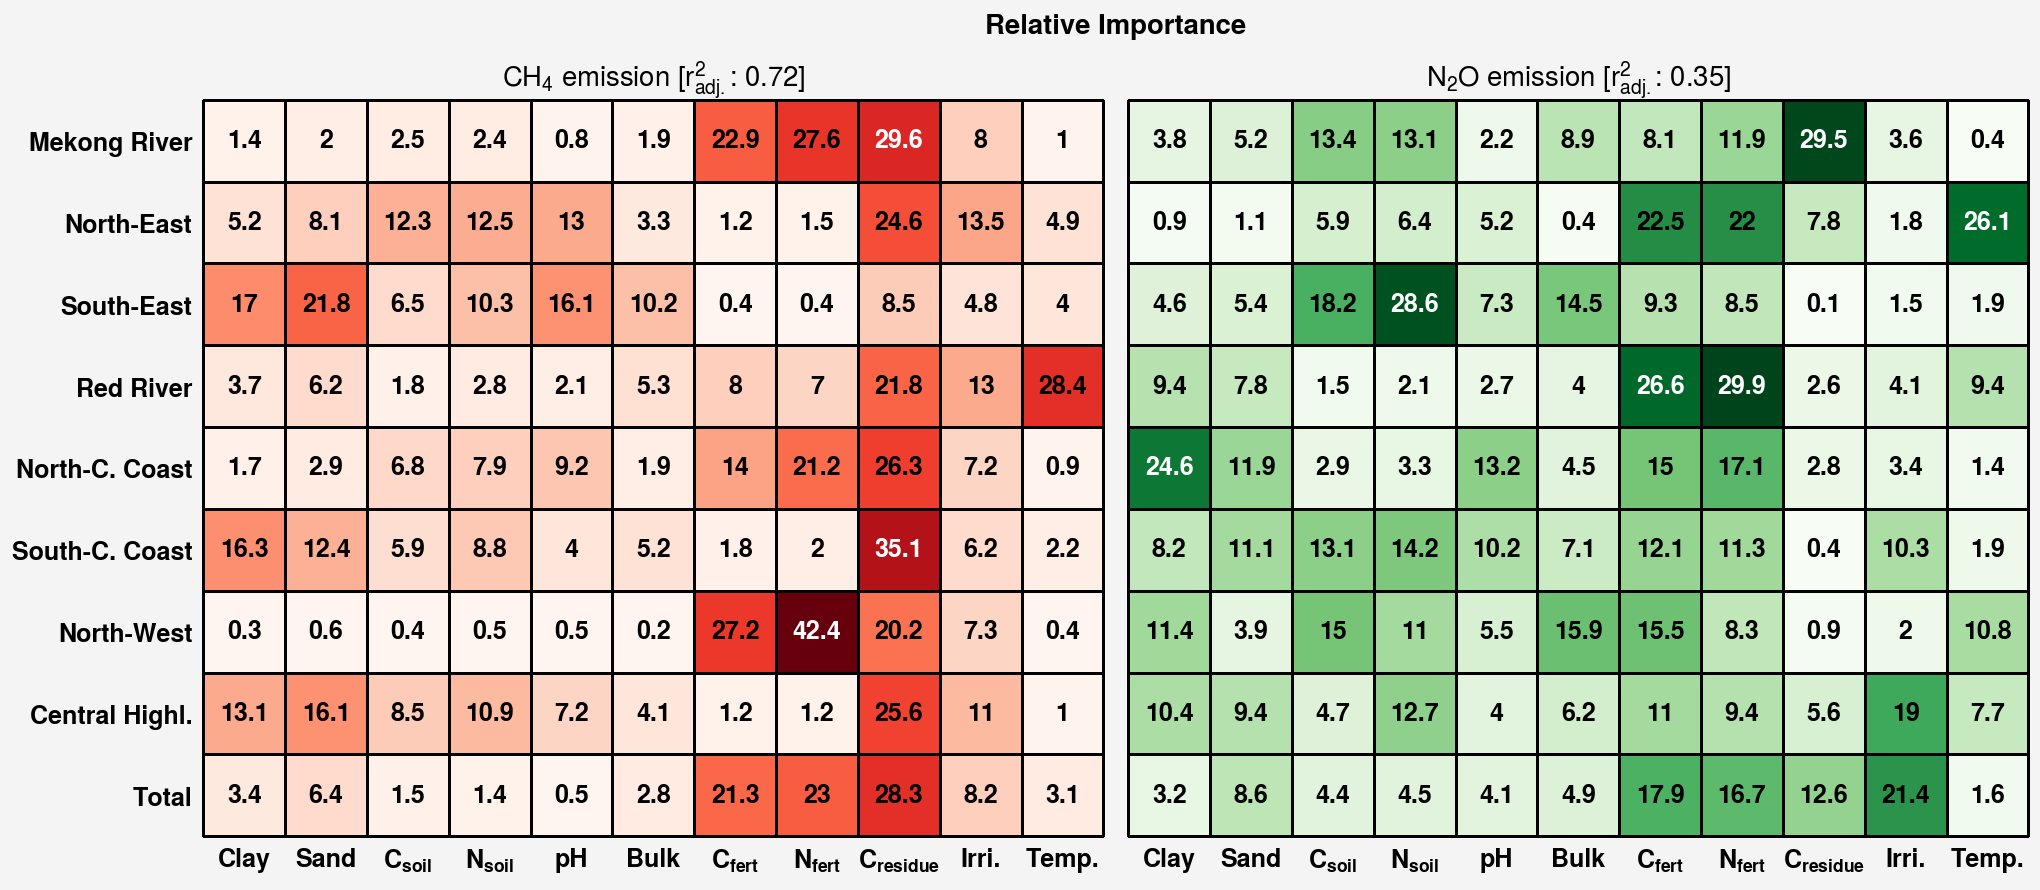

In [24]:
# Covariance matrix plot
fig, ax = plot.subplots([1,2], refwidth=4.5)
m = ax[0].heatmap(
    table_ch4, cmap='Reds', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'bold'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)

m = ax[1].heatmap(
    table_n2o, cmap='Greens', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'bold'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)

ax[0].format(
    suptitle='Relative Importance', title=f'CH$_4$ emission [r$^2_{{adj.}}$: {regional_results_ch4[0].r2adj:.2f}]',
    xloc='bottom', yloc='left', yreverse=True, ticklabelweight='bold',
    alpha=0, linewidth=0, tickpad=4, #xrotation=90,
)

ax[1].format(
    title=f'N$_2$O emission [r$^2_{{adj.}}$: {regional_results_n2o[0].r2adj:.2f}]',
    xloc='bottom', yloc='left', yreverse=True, ticklabelweight='bold',
    alpha=0, linewidth=0, tickpad=4, #xrotation=90,
)

In [25]:
plot_pdf_png(fig, 'relaimpo')

In [28]:
table_ch4.dtypes

Clay             float64
Sand             float64
C$_{soil}$       float64
N$_{soil}$       float64
pH               float64
Bulk             float64
C$_{fert}$       float64
N$_{fert}$       float64
C$_{residue}$    float64
Irri.            float64
Temp.            float64
dtype: object